In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import spatialproteomics as sp
import matplotlib.pyplot as plt
import tifffile
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
from glob import glob
from tqdm.auto import tqdm
from adjustText import adjust_text
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
from scipy.interpolate import interp1d
from sklearn.metrics import auc
import scanpy as sc

BASE_PATH = '/g/huber/users/meyerben/data/codex/BNHL/data_for_publication/'


# Load the custom style from your .ini file
mpl.style.core.use('pub_matplotlib_rc.ini')

font_size = 6.5
point_border_color = '#49566d'  # dark gray
line_width = 0.6

# Set global font size
plt.rcParams.update({"font.size": font_size})  # Adjust the value as needed

formatted_dict = {
    'B cell': 'B cell',
    'B_prol': r'B$_{\mathrm{prol}}$',
    'Dendritic cell': 'Dendritic cell',
    'Endothelial cell': 'Endothelial cell',
    'M2': 'M2',
    'Macrophage': 'Macrophage',
    'Myeloid cell': 'Myeloid cell',
    'Stromal cell': 'Stromal cell',
    'T_fh': r'T$_{\mathrm{fh}}$',
    'T_h': r'T$_{\mathrm{h}}$',
    'T_h_mem': r'T$_{\mathrm{h}}$ mem',
    'T_h_naive': r'T$_{\mathrm{h}}$ naive',
    'T_terminally_exh': r'T$_{\mathrm{term\ exh}}$',
    'T_tox': r'T$_{\mathrm{tox}}$',
    'T_tox_mem': r'T$_{\mathrm{tox}}$ mem',
    'T_tox_naive': r'T$_{\mathrm{tox}}$ naive',
    'T_reg': r'T$_{\mathrm{reg}}$',
    'T_progenitor_exh': r'T$_{\mathrm{prog\ exh}}$',
    'T_reg_Helios': r'T$_{\mathrm{reg}}$ Helios',
    'T cell': 'T cell',
    'T_exh': r'T$_{\mathrm{exh}}$'
}

entity_colors = {'LN': '#9dcbec', # light blue
                 'CLL': '#FAD0CE', 'LPL': '#EEBFBD', 'MZL': '#E2AFAC', 
                 'FL 1': '#D59E9C', 'FL 2': '#C98D8B', 'FL 3a': '#BD7C7A', 'FL 3b': '#B16C69', 
                 'MCL': '#A55B58', 'DLBCL': '#994A47', 'PMBCL': '#8C3937', 'Burkitt': '#802926', 'BLBL': '#741815'}

entity_class_colors = {'LN': '#9dcbec', 'indolent': '#E2AFAC', 'aggressive': '#741815'}

# red, blue, green, yellow, purple, teal (from the nature color palette: https://www.nature.com/documents/natrev-artworkguide.pdf) 
celltype_colors = {'B cell': '#5799d1', 'T cell': '#ebc850', 'Myeloid cell': '#de6866', 'Dendritic cell': '#4cbcbd', 'Macrophage': '#bb7cb4', 'Stromal cell': '#62b346', 'Endothelial cell': '#bf997d'}

nh_mapping_dict = {'Neighborhood 0': 'T/Dendritic',
                      'Neighborhood 1': 'T',
                      'Neighborhood 2': 'Mixed',
                      'Neighborhood 3': 'B_prol/T_fh',
                      'Neighborhood 4': 'T_h/T_reg',
                      'Neighborhood 5': 'B',
                      'Neighborhood 6': 'Myeloid/Macro'}

entity_grouping_dict = {'LN': 'LN', 'FL 1': 'indolent', 'FL 2': 'indolent', 'FL 3a': 'indolent', 'FL 3b': 'indolent', 'MZL': 'indolent', 'DLBCL': 'aggressive', 'Burkitt': 'aggressive', 'PMBCL': 'aggressive', 'DLBCL': 'aggressive', 'BLBL': 'aggressive'}

# colors for neighborhoods
neighborhood_colors = {'B': '#5799d1',
                       'B_prol/T_fh': '#154e91',
                       'T/Dendritic': '#fef1c3',
                       'T': '#ebc850',
                       'T_h/T_reg': '#cca02d',
                       'Myeloid/Macro': '#de6866',
                       'Mixed': '#c8ceda'}

In [2]:
df = pd.read_csv(os.path.join(BASE_PATH, 'derived_data/wsi_squidpy_df.csv'), index_col=0)

In [3]:
sample_ids = df['sample_id'].unique()
sample_ids

array(['DLBCL_1', 'DLBCL_3', 'DLBCL_5', 'DLBCL_2', 'DLBCL_4'],
      dtype=object)

In [4]:
def plot_squidpy_results(ax, sample, show_y_labels=True, show_cbar=True, row_order=celltype_colors.keys(), col_order=celltype_colors.keys()):
    adata_df = df.copy()
    adata_df = adata_df[adata_df['sample_id'] == sample]
    adata_df = adata_df[['ct1', 'ct2', 'interaction_score']]

    # Group by phenotype and neighbour_phenotype, then compute the mean
    heatmap_data = adata_df.groupby(['ct1', 'ct2'])['interaction_score'].mean().unstack()
    
    # **Set row and column order**
    if row_order is not None:
        heatmap_data = heatmap_data.reindex(index=row_order)
    if col_order is not None:
        heatmap_data = heatmap_data.reindex(columns=col_order)

    # Plot heatmap
    sns.heatmap(heatmap_data, cmap="coolwarm", annot=False, center=0, cbar=show_cbar, ax=ax, 
                linewidths=line_width, square=True, vmin=-500, vmax=750, 
                cbar_kws={'label': 'Interaction Score'})
    
    # Format x-tick labels
    xtick_labels = [label.get_text() for label in ax.get_xticklabels()]
    formatted_labels = [formatted_dict.get(label, label) for label in xtick_labels]
    ax.set_xticklabels(formatted_labels, fontsize=font_size)

    # Format y-tick labels
    ytick_labels = [label.get_text() for label in ax.get_yticklabels()]
    formatted_labels = [formatted_dict.get(label, label) for label in ytick_labels]
    ax.set_yticklabels(formatted_labels, fontsize=font_size)

    ax.set_xlabel("")
    ax.set_ylabel("")
    if not show_y_labels:
        ax.set_yticks([])
        
    ax.set_title(sample, fontsize=font_size)

In [5]:
print(df['interaction_score'].min())
print(df['interaction_score'].max())

-490.8431396897499
732.0769062974068


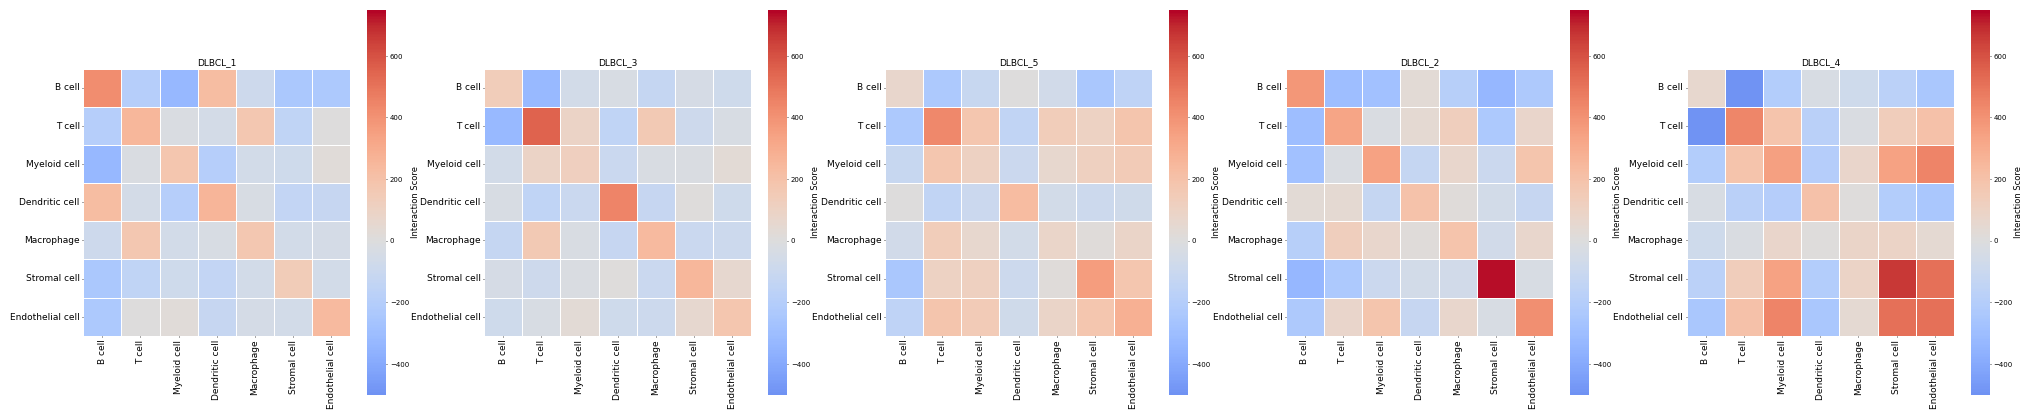

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
for i, sample_id in enumerate(sample_ids):
    plot_squidpy_results(ax[i], sample_id)
plt.show()

In [7]:
df['ct_combination'] = [row['ct1'] + ' - ' + row['ct2'] for i, row in df.iterrows()]

In [8]:
ct_combinations = [f"{ct} - {ct2}" for ct in list(celltype_colors.keys()) for ct2 in list(celltype_colors.keys())]

unique_combinations = []
seen_pairs = set()

for combo in ct_combinations:
    ct1, ct2 = combo.split(" - ")
    pair = tuple(sorted([ct1, ct2]))  # Sort to maintain symmetry

    if pair not in seen_pairs:
        unique_combinations.append(combo)
        seen_pairs.add(pair)  # Mark as seen

# Output the filtered list
print(unique_combinations)

['B cell - B cell', 'B cell - T cell', 'B cell - Myeloid cell', 'B cell - Dendritic cell', 'B cell - Macrophage', 'B cell - Stromal cell', 'B cell - Endothelial cell', 'T cell - T cell', 'T cell - Myeloid cell', 'T cell - Dendritic cell', 'T cell - Macrophage', 'T cell - Stromal cell', 'T cell - Endothelial cell', 'Myeloid cell - Myeloid cell', 'Myeloid cell - Dendritic cell', 'Myeloid cell - Macrophage', 'Myeloid cell - Stromal cell', 'Myeloid cell - Endothelial cell', 'Dendritic cell - Dendritic cell', 'Dendritic cell - Macrophage', 'Dendritic cell - Stromal cell', 'Dendritic cell - Endothelial cell', 'Macrophage - Macrophage', 'Macrophage - Stromal cell', 'Macrophage - Endothelial cell', 'Stromal cell - Stromal cell', 'Stromal cell - Endothelial cell', 'Endothelial cell - Endothelial cell']


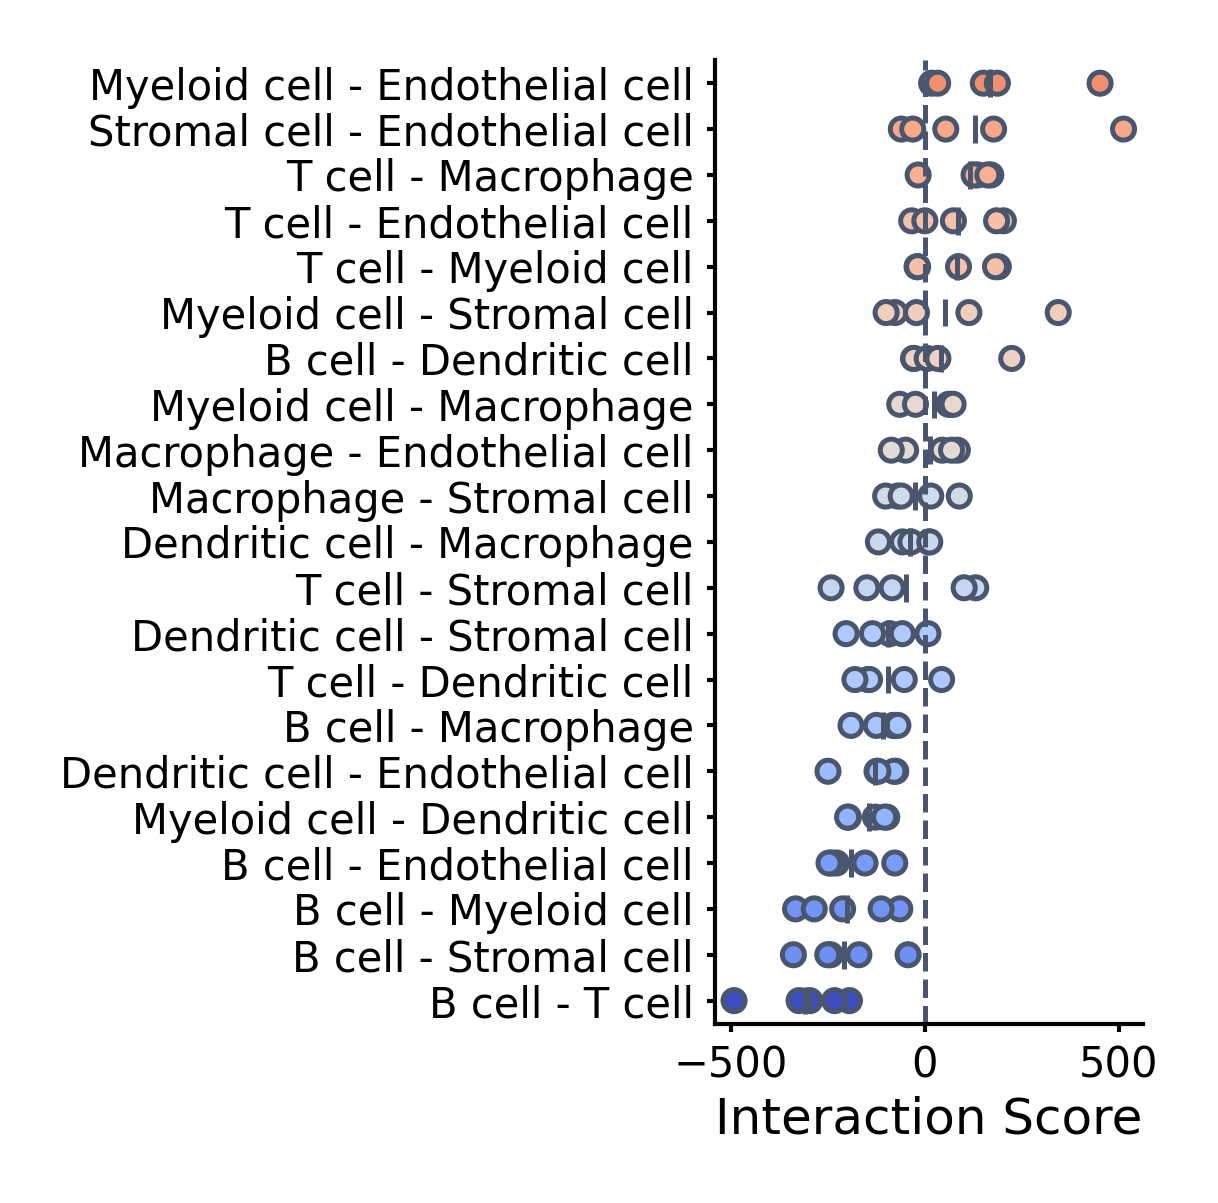

In [9]:
point_size = 7

# Sort by mean interaction score
df_filtered = df[df['ct1'] != df['ct2']]
df_filtered = df_filtered[df_filtered['ct_combination'].isin(unique_combinations)]

# Compute mean interaction scores
mean_scores = df_filtered.groupby('ct_combination')['interaction_score'].mean()
df_sorted = df_filtered.sort_values(by='ct_combination', key=lambda x: x.map(mean_scores), ascending=False)

# Create symmetric normalization centered at 0 using actual data range
max_abs = max(abs(mean_scores.min()), abs(mean_scores.max()))
norm = plt.Normalize(vmin=-max_abs, vmax=max_abs)  # Dynamic symmetric range
cmap = plt.cm.coolwarm

# Map colors based on mean scores using the normalization
df_sorted['mean_color'] = df_sorted['ct_combination'].map(mean_scores).apply(lambda x: cmap(norm(x)))

# Plot
plt.figure(figsize=(2, 2), dpi=600)

# Strip plot with pre-computed colors
sns.scatterplot(data=df_sorted, y='ct_combination', x='interaction_score', 
              color=df_sorted['mean_color'],  # Use precomputed colors
              alpha=1, legend=False, s=point_size,
              edgecolor=point_border_color, linewidth=line_width)

# Add mean interaction score lines
for i, ct in enumerate(df_sorted['ct_combination'].unique()):
    mean_value = mean_scores[ct]
    plt.vlines(mean_value, i - 0.3, i + 0.3, color=point_border_color, linewidth=line_width, zorder=50)

# Add reference line at 0
plt.axvline(0, color=point_border_color, linestyle='--', linewidth=line_width)

sns.despine()
plt.xlabel('Interaction Score')
plt.ylabel('')

# Remove y-axis padding
ax = plt.gca()
ax.margins(y=0.01)

plt.tight_layout()
plt.show()